In [1]:
import numpy as np
import pandas as pd

from setuptools import setup
from Cython.Build import cythonize
import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
import galpy.potential
import galpy

%matplotlib inline
from matplotlib import pyplot as pl
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PatchCollection
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.patches import FancyArrowPatch
from matplotlib.patches import Circle as c

import matplotlib.pyplot as plt

import ipyvolume as ipv

from galpy.util import bovy_conversion, bovy_plot
from galpy.orbit import Orbit
from galpy.potential import potential_c_ext
from astropy.units import Msun, AU,kpc,Gyr

# functions for plotting posteriors
import corner
from scipy.stats import gaussian_kde

from time import time
import sys
import os


###Import potentials
from galpy.potential import NFWPotential
from galpy.potential import KeplerPotential
from galpy.potential import LogarithmicHaloPotential, ChandrasekharDynamicalFrictionForce
from galpy.potential import MovingObjectPotential
from galpy.potential import MiyamotoNagaiPotential


from galpy.potential import HernquistPotential
from galpy.potential import MWPotential2014
from galpy.potential import PlummerPotential
from galpy.potential import PowerSphericalPotentialwCutoff

In [2]:
rcparams = {}
rcparams['text.usetex'] = True
rcparams['axes.linewidth'] = 0.5
rcparams['font.family'] = 'sans-serif'
rcparams['font.size'] = 22

In [3]:
MWPotential2014[2]*=1.5

cdf= ChandrasekharDynamicalFrictionForce(GMs=5.*10.**10.*u.Msun,rhm=5.*u.kpc,
                                      dens=MWPotential2014)*2/3

# import LMC known final conditions and orbit from Galpy

In [4]:
ts= np.linspace(0,-10,1000)*u.Gyr
LMC2=Orbit.from_name('LMC')

In [5]:
print(LMC2.ra(ts[0]),',',LMC2.dec(ts[0]),',',LMC2.dist(ts[0]),',',LMC2.pmra(ts[0]),',',LMC2.pmdec(ts[0]),',',LMC2.vlos(ts[0]))

78.77000000000004 , -69.00999999999998 , 50.10000000000001 , 1.8499999999999996 , 0.2340000000000017 , 262.20000000000005


In [6]:
print(LMC2.x(ts[0]),',',LMC2.y(ts[0]),',',LMC2.z(ts[0]),',',LMC2.vx(ts[0]),',',LMC2.vy(ts[0]),',',LMC2.vz(ts[0]))

1.007225032802711 , -41.04364571952311 , -27.845492259796814 , 57.12682922619408 , -236.34235587484554 , 208.8919439319931


In [7]:
LMC2.integrate(ts,MWPotential2014+ cdf)

# trivial disk plot?

<ipython-input-8-71f75307557e>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()



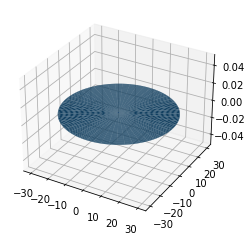

In [8]:
R = np.linspace(0, 30, 100)
h = 0
u1 = np.linspace(0,  2*np.pi, 100)

x = np.outer(R, np.cos(u1))
y = np.outer(R, np.sin(u1))
z = h * np.outer(np.ones(np.size(u1)), np.ones(np.size(u1)))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x,y,z) # z in case of disk which is parallel to XY plane is constant and you can directly use h
fig.show()

# plotting the center of the MW galaxy and LMC orbit

In [9]:
#ts= np.linspace(0,-10,1000)*u.Gyr

img=ipv.figure()
#ax = img.add_subplot(111, projection='3d')
ipv.xlabel('y ')
ipv.ylabel('x ')
#ax.set_zlabel('z Kpc')
#ax.set_ylim(-200,250)
#ax.set_xlim(-250,250)
#ax.set_zlim(-100,100)


#MW Galaxy center

a=np.zeros((1,1))
b=np.zeros((1,1))
c=np.zeros((1,1))

ipv.scatter(a,b,c,marker='sphere',color='blue')


# Sun

sun_x=np.array([8.5])
sun_y=np.array([0.0])
sun_z=np.array([25/100])

ipv.scatter(sun_y,sun_x,sun_z,marker='sphere', color='gold')

#LMC

LMC_t0_x=np.array([LMC2.x(ts[0])])
LMC_t0_y=np.array([LMC2.y(ts[0])])
LMC_t0_z=np.array([LMC2.z(ts[0])])

ipv.scatter(LMC2.y(ts), LMC2.x(ts), LMC2.z(ts),marker='sphere')

ipv.scatter(LMC_t0_y,LMC_t0_x,LMC_t0_z,marker='sphere', color='cyan',label='t=0')



ipv.plot_surface(x,y,z,color='black')


ipv.show()

# actual/simulated initial conditions of LMC

In [10]:
Truths=[LMC2.ra(ts[-1]),LMC2.dec(ts[-1]),LMC2.dist(ts[-1]),LMC2.pmra(ts[-1]),LMC2.pmdec(ts[-1]),LMC2.vlos(ts[-1])]

In [11]:
print(Truths)

[343.87093171988687, -1.7532314472757664, 351.038069271151, 0.06557544201581109, -0.13424314509661045, -73.631627621767]


In [12]:
print(LMC2.x(ts[-1]),',',LMC2.y(ts[-1]),',',LMC2.z(ts[-1]),',',LMC2.vx(ts[-1]),',',LMC2.vy(ts[-1]),',',LMC2.vz(ts[-1]))

-63.11417388706689 , 201.88275349511738 , -278.2126526817491 , -9.322383481638047 , -12.637840059746372 , -77.98605528081086


# Model: Bovy Integrations output x,y,z,vx,vy,vz

In [13]:
# sets up model
# input parameters we are trying to find: [ra,dec,dist,pmra,pmdec,vlos] 10 Gyrs ago
# output the data we want to compare with known data: [x,y,z,vx,vy,vz] today


def model(theta):
    ra,dec,pmra,pmdec,vlos=theta[0],theta[1],theta[2],theta[3],theta[4]
   # print('ra=',r)
    ts=np.linspace(0,10,1000)*u.Gyr
    dist = 351 
    LMC=Orbit([ra,dec,dist,pmra,pmdec,vlos],radec=True)
                                 
    LMC.integrate(ts,MWPotential2014 + cdf,method='dopr54_c')#+ cdf)
   
    
    Final_position= [LMC.x(ts[-1]),LMC.y(ts[-1]),LMC.z(ts[-1]),LMC.vx(ts[-1]),LMC.vy(ts[-1]),LMC.vz(ts[-1])]
    #Final_Conditions=[LMC.ra(ts[-1]),LMC.dec(ts[-1]),LMC.dist(ts[-1]),LMC.pmra(ts[-1]),LMC.pmdec(ts[-1]),LMC.vlos(ts[-1])]
   
    return(Final_position)

In [14]:
data=[1.0072250328026926, -41.043645719523106, -27.845492259796814, 57.126829226194, -236.34235587484554, 208.89194393199307] # [x,y,z,vx,vy,vz] of LMC today
sigma=[0.33,1.89,1.28,7.99,12.60,16.68] # error in known data

# The posterior probability is the probability of the parameters θ given the evidence X; p(θ|X)

In [15]:
# I note that the posterior only depends on the parameters.

def log_posterior(theta,data,sigma):
    
    lp=log_prior(theta)
    
    if not np.isfinite(lp):
        return -np.inf
    

    ls=log_likelihood(theta,data,sigma)
    
  
    return lp + ls

# The likelihood probability is the probability of the evidence X given the parameters θ;   p(X|θ)

In [16]:
def log_likelihood(theta,data,sigma):

    ra,dec,pmra,pmdec,vlos=theta
    
    #model
    Final_pos=model(theta)

    #print(Final_pos[0])
    #print('hi')
   # print(Final_pos)
    
#     time1 = time()
    f=0
    for i in range(0,len(data)):
        a=data[i]-Final_pos[i]
        
        b=(a/sigma[i])
        c=b**2
       
        f+=c
#     time2 = time()  
#     print(time2-time1)
#     with open(f'log.csv', 'a') as g:
#         print  (-0.5* f,file=g)
#     g.close()
    
    
    #get array x,y,z,vx,vy,vz
    
    return -0.5* f #array of known today conditions#data))/sigma)

# The prior probability is the probability of an event before new data is collected.

This is the best rational assessment of the probability of an outcome based on the current knowledge before an experiment is performed. <span style="color:blue">The prior probability of an event will be revised as new data or information becomes available, to produce a more accurate measure of a potential outcome. That revised probability becomes the posterior probability</span> and is calculated using Bayes' theorem. In statistical terms, the posterior probability is the probability of event A occurring given that event B has occurred.    
For example, three acres of land have the labels A, B, and C. One acre has reserves of oil below its surface, while the other two do not. The prior probability of oil being found on acre C is one third, or 0.333. But if a drilling test is conducted on acre B, and the results indicate that no oil is present at the location, then the posterior probability of oil being found on acres A and C become 0.5, as each acre has one out of two chances.  
If we are interested in the probability of an event of which we have prior observations; we call this the prior probability. We'll deem this event A, and its probability P(A). If there is a second event that affects P(A), which we'll call event B, then we want to know what the probability of A is given B has occurred. In probabilistic notation, this is P(A|B), and is known as posterior probability or revised probability. This is because it has occurred after the original event, hence the post in posterior. (source: https://www.investopedia.com/terms/p/prior_probability.asp)

In [65]:
# Question, do I need to include noise in my data?
# do all parameters need to have priors?
# if yes, how do you know which type of prior?
# I dont think this is the right way to cut off the angles.

def log_prior(theta):
    lp=0
    
    ra,dec,pmra,pmdec,vlos=theta
    
    #uniform prior ranges
    
    ra_min =-360
    ra_max=360
    
    dec_min= -90
    dec_max= 90
    
   # dist_min=0       # gaussian?
    #dist_max= np.inf
    
    
    dist = 351 

    pmra_min=-10
    pmra_max=10
    
    pmdec_min=-10
    pmdec_max=10
    
    vlos_min=0
    vlos_max=np.inf 
    
    # I am not sure what the return here should be
    
#     lp=0 if (ra_min<ra<ra_max and dec_min<dec<dec_max and pmra_min<pmra<pmra_max  and  pmdec_min<pmdec<pmdec_max and 0<dist<500 and vlos_min<vlos<vlos_max) else -np.inf
    lp=0 if (ra_min<ra<ra_max and dec_min<dec<dec_max and pmra_min<pmra<pmra_max  and  pmdec_min<pmdec<pmdec_max and vlos_min<vlos<vlos_max) else -np.inf

 
   
    return lp 


# log likelihood: $- \frac{1}{2}  \chi^2$
## $\chi^2= \sum_{i=0}^{\text{# parameters}} \frac{(\text{data-prediction(parameters)})^2}{eror^2}$

# Set bounds on Parameters with the prior
## I'll try a flat prior first

# MCMC set up: We need to decide on an initial number of ensemble points and initialise the samples, i.e., set starting points for them

# Initializing ensemble points

In [66]:
print(Truths) # see the vales we get from one integration, initial values should be close to these

[343.87093171988687, -1.7532314472757664, 351.038069271151, 0.06557544201581109, -0.13424314509661045, -73.631627621767]


# A walker is an N dimensional numpy array of ...

more walkers, less ensambles

In [76]:
Nens = 20 # number of ensembles

# Making starting point of all to ensembles around what we expect the value to be.
# The ensembles have to have 6 elements/parameters: ra,dec,dist,pmra,pmdec,vlos
inisamples=np.zeros((Nens,5)) # a position vector with 20 identical arrays that each have 6 elements/parameters
inisamples[:,0]=Truths[0] # ra
inisamples[:,1]=Truths[1] # dec
# inisamples[:,2]=Truths[2] # dist
inisamples[:,2]=Truths[3] # pmra
inisamples[:,3]=Truths[4] # pmdec
inisamples[:,4]=Truths[5] # vlos

ndims = inisamples.shape[1] # the number of dimensions in the parameter space (basically the number of parameters)
                            # 6 in this case

## burn in runs

In [68]:
# number of walkers = nburnin + nsamples
Nburnin = 200   # number of steps in the MCMC chain that lets the walkers explore the parameter space a bit and get settled
Nsamples = 400  # number of final posterior samples
# number of walkers in 1 ensemble Nens times

# https://emcee.readthedocs.io/en/stable/user/sampler/

In [69]:
import emcee # import the emcee package
x=inisamples

print('emcee version: {}'.format(emcee.__version__))

# for bookkeeping set number of likelihood calls to zero
log_likelihood.ncalls = 0

# set additional args for the posterior (the data, the noise std. dev., and the abscissa)
argslist = (data, sigma)

# set up the sampler
sampler = emcee.EnsembleSampler(Nens, ndims, log_posterior, args=argslist)
                             # (# of walkers, # of parameters, log posterioir function, extra positional arguments used in the log posterior function)
    

emcee version: 3.0.2


In [70]:
# making slight variations in starting points in position vector each time
pos= inisamples +  1e-2 * np.random.randn(Nens, ndims)
log_prob=sampler.compute_log_prob(pos)

In [71]:
pos

array([[ 3.43894748e+02, -1.74996916e+00,  6.01975464e-02,
        -1.27693017e-01, -7.36375947e+01],
       [ 3.43843877e+02, -1.75662647e+00,  7.06836362e-02,
        -1.37543307e-01, -7.36246452e+01],
       [ 3.43878220e+02, -1.76890925e+00,  6.30474448e-02,
        -1.37194299e-01, -7.36364322e+01],
       [ 3.43868583e+02, -1.75746372e+00,  6.41082429e-02,
        -1.24193735e-01, -7.36351453e+01],
       [ 3.43890438e+02, -1.75142693e+00,  7.63444916e-02,
        -1.33446218e-01, -7.36350990e+01],
       [ 3.43857333e+02, -1.73022066e+00,  5.99016300e-02,
        -1.35768005e-01, -7.36275251e+01],
       [ 3.43885686e+02, -1.75964516e+00,  6.05366245e-02,
        -1.30492937e-01, -7.36215303e+01],
       [ 3.43873330e+02, -1.75296631e+00,  5.47655143e-02,
        -1.26953241e-01, -7.36494500e+01],
       [ 3.43888080e+02, -1.74512947e+00,  7.06337551e-02,
        -1.25084568e-01, -7.36372728e+01],
       [ 3.43859317e+02, -1.76636615e+00,  7.59453693e-02,
        -1.40877124e-01

In [72]:
log_prob # A vector of log-probabilities with one entry for each walker in this sub-ensemble (log_prob[0])
# A function that takes a vector in the parameter space as input
   # and returns the natural logarithm of the posterior probability (up to an additive constant) for that position

# also outputs "blob", the list of meta data returned by log_posterior at this position
    # or None if nothing was returned.

(array([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf]),
 None)

## run samples and take out burn in samples

In [63]:
# pass the initial samples and total number of samples required
t0 = time() # start time
sampler.run_mcmc(pos, Nsamples+Nburnin,progress=True);
              # (initial state or position vector, number of steps)
t1 = time()

timeemcee = (t1-t0)
print("Time taken to run 'emcee' is {} seconds".format(timeemcee))

# extract the samples (removing the burn-in)
# runs the burn in walkers but extracts them afterwards
samples_emcee = sampler.chain[:, Nburnin:, :].reshape((-1, ndims))

 55%|█████▌    | 330/600 [00:00<00:00, 1611.29it/s]

/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]



100%|██████████| 600/600 [00:00<00:00, 1804.71it/s]

Time taken to run 'emcee' is 0.3363509178161621 seconds


In [64]:
# The fraction of proposed steps that were accepted for each ensemble
sampler.acceptance_fraction

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [26]:
labels=["ra", "dec","pmra","pmdec","vlos"]

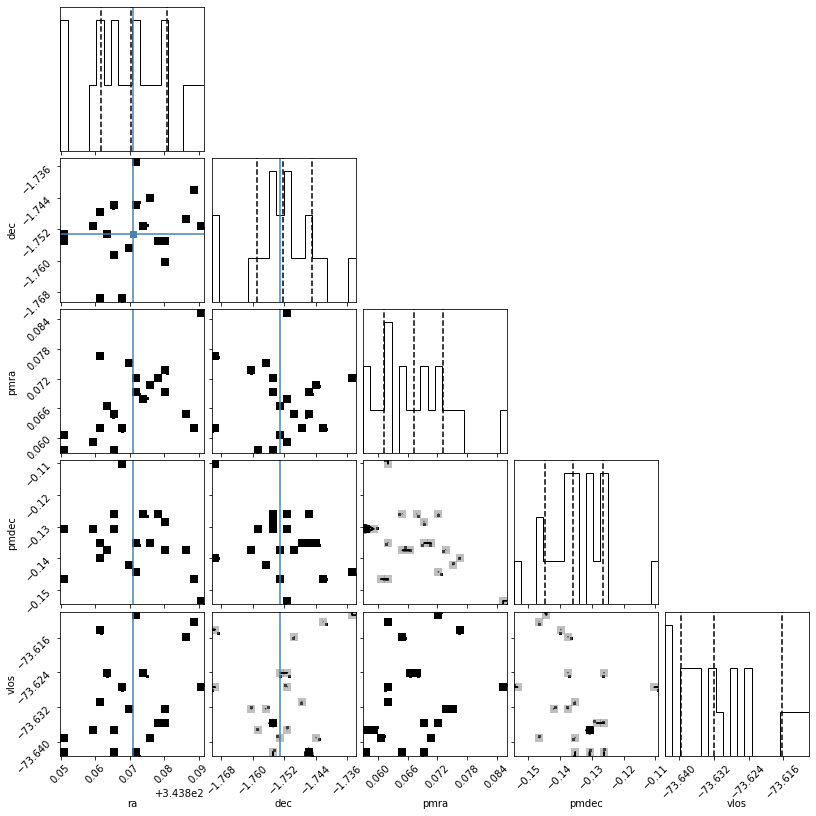

In [27]:
fig = corner.corner(samples_emcee, labels=labels,
                      truths=Truths,quantiles=[0.16, 0.5, 0.84])
fig.savefig("MCMC_LMC_initial_feb28_dist_fixed.png")

In [28]:
flat_samples = sampler.get_chain(discard=500,flat=True)
print(flat_samples.shape)

(2000, 5)


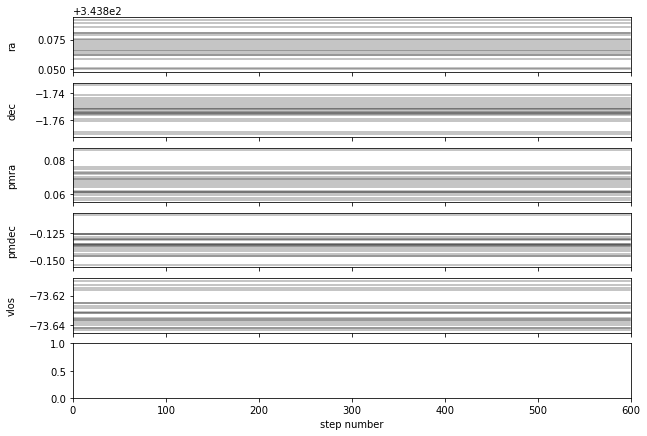

In [29]:
fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
#labels = ["m", "b", "log(f)"]
for i in range(ndims):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

# To do 2

In [30]:
# from IPython.display import display, Math
# ndim=6
# #MC=[]
# #MC_p=[]
# #MC_m=[]
# #Q=[]
# for i in range(ndim):
#     mcmc = np.percentile(flat_samples[:, i], [16, 50, 84]) # this gives me a lower bound where none of the data points are, where 50% of the point are is the value reported and upperbound that encompasses 100% of data points
    
#     #MC.append(mcmc[1])
#     #MC_p.append(mcmc[2])
#    # MC_m.append(mcmc[0])
#     q = np.diff(mcmc)
#    # Q.append(q)
#     txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
#     txt = txt.format(mcmc[1], q[0], q[1], labels[i])
#     display(Math(txt))



# mcmc

In [31]:
ndim=6
mcmc = [0,1,2,3,4,5]
q = [0,1,2,3,4,5]
for i in range(ndim):
    mcmc[i] = np.percentile(flat_samples[:, i], [16, 50, 84]) # this gives me a lower bound where none of the data points are, where 50% of the point are is the value reported and upperbound that encompasses 100% of data points

    q[i] = np.diff(mcmc[i])

IndexError: index 5 is out of bounds for axis 1 with size 5

In [ ]:
pm=[0,1,2,3,4,5]

for i in range(ndim):
    pm[i]=pd.DataFrame({"16%":[mcmc[i][0]],"50%":[mcmc[i][1]],"84%":[mcmc[i][2]]})

cc=pd.concat([pm[0],pm[1],pm[2],pm[3],pm[4],pm[5]],ignore_index=True)

In [ ]:
cc

In [ ]:
x=cc['50%'].tolist()
x

In [ ]:
y=(1,2,3,4,5,6)

In [ ]:
yerr = np.array([q[0].tolist(),q[1].tolist(),q[2].tolist(),q[3].tolist(),q[4].tolist(),q[5].tolist()]).T

In [ ]:
yerr

In [ ]:
# plt.xlabel('value', fontsize=12)
# plt.ylabel('error', fontsize=12)
# plt.errorbar(x, y,yerr, fmt='rD', capsize=3)

In [ ]:
Truths

In [ ]:
# plt.scatter(y,Truths,marker="*")

In [ ]:
labels

In [ ]:
ra_error=[[yerr[0][0]],[yerr[1][0]]]

dec_error=[[yerr[0][1]],[yerr[1][1]]]

dist_error=[[yerr[0][2]],[yerr[1][2]]]

pmra_error=[[yerr[0][3]],[yerr[1][3]]]

pmdec_error=[[yerr[0][4]],[yerr[1][4]]]

vlos_error=[[yerr[0][5]],[yerr[1][5]]]

errors=[ra_error,dec_error,dist_error,pmra_error,pmdec_error,vlos_error]

In [ ]:
errors

In [ ]:
for i in range(6):
    plt.errorbar(y[i],x[i],yerr=errors[i], fmt='^', capsize=4)
    plt.plot(y[i],Truths[i],marker='*',c="black")
    plt.title(labels[i])
    plt.show()

In [ ]:
# for i in range(6):
#     fig, ax1 = plt.subplots()

#     ax2 = ax1.twinx()
#     ax2.scatter(y[i],Truths[i],marker='*',c='black')

#     ax1.errorbar(y[i],x[i],yerr=ra_error, fmt='^', capsize=4)
#     ax1.set_title(labels[i])
#     fig.savefig(labels[i]+".png")

https://pythondata.com/visualizing-data-overlaying-charts/